<a href="https://colab.research.google.com/github/AashiDutt/Pytorch/blob/master/CIFAR10_using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# CIFAR DATASET

# to overcome overfitting:
#-use data augmentation : create new data(same data but zoomed,rotated etc) from model to use in training process
# allows our model to see images from different persective
#- changing learning rate
#- adding more layers

In [15]:
# CODE

# Loading Images and Transforms

!pip3 install torch torchvision

In [0]:

import torch
from torchvision import datasets, transforms

# transformations are used to preprocess the dataset before it is fed to neural network
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [0]:
# making use of Colab GPU using Cuda
# Runtime -->Change runtime type--> Hardware --> GPU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
# CIFAR10 images are 32x32
#applying data augmentation transform to training dataset(only)
transform_train = transforms.Compose([transforms.Resize((32,32)),transforms.RandomHorizontalFlip(),transforms.RandomRotation(10),transforms.RandomAffine(0,shear=10 ,scale=(0.8,1.2)),transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2),transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])

transform = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
#Compose allows us to chain together transformations

#we chose value 0.5 because we want values in range 0 to 1,creating a range (-1 to 1)

# Normalizing the image 
# formula z = (x - mean)/ standard deviation
# eg. (min value - mean)/standard deviation = (0-0.5)/0.5 = -1
# (max value- mean)/sd = (1-0.5)/0.5 =1  therefore range = (-1,1)

#Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) = Normalize(mean,standard deviation)
#Normalize the value of each tensor of image size channel height and widthin 1st set of brackets
#converts numpy array(of range 0-255) to tensor (a float tensor in range 0 to 1)

# defining root directory of training_dataset
training_dataset = datasets.CIFAR10(root ='./data', train = True, download = True,transform =transform_train )
validation_dataset = datasets.CIFAR10(root ='./data', train = False, download = True,transform =transform )


training_loader = torch.utils.data.DataLoader(dataset = training_dataset, batch_size = 100, shuffle = True)
validation_loader =torch.utils.data.DataLoader(dataset = training_dataset, batch_size = 100, shuffle = False)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
# to plot an image convert it again to a numpy array
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  # clone to create new copy of tensor
  # use detach function to call numpy
  
  image = image.transpose(1,2,0)
  # we have shape of tensor as(1,28,28)(single colorchannel,shape(28,28)) but to plot a grayscale image we need tensor of shape (28,28,1)
  # we swap axis using transpose means swap axis 0 for axis 1, axis 1 fo axis 2 and axis 0 in the end
  #print(image.shape)
  # denormalizing the image
  # x=z * standard deviation + mean
  
  image = image *np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
  image = image.clip(0,1)
  # to reconvert range from (-1,1) to (1,1) we use clip function
  return image


In [0]:
classes =('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

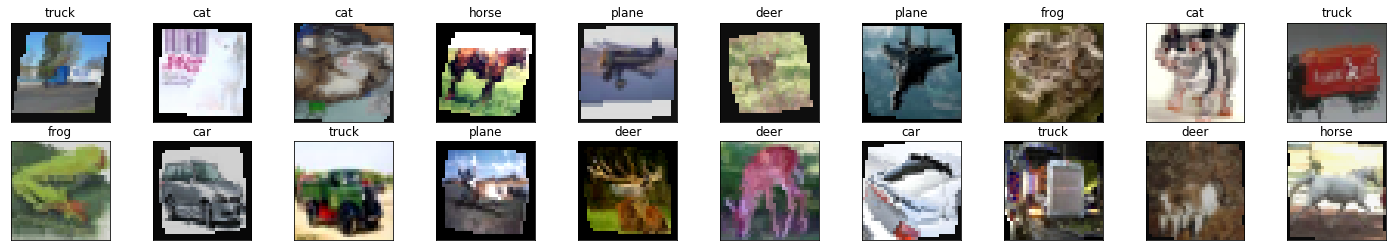

In [21]:
# creating a iterator 
# iter creates an object that allows us to go through the iterable of training loader one element at a time 
dataiter = iter(training_loader)
images , labels = dataiter.next()
#images, labels = dataiter.next() # gets first batch of training data
fig = plt.figure(figsize =(25,4))

for idx in np.arange(20):
  ax =fig.add_subplot(2,10,idx+1,xticks =[],yticks =[])   # 2 rows 10 columns per row and index
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [0]:
class LeNet(nn.Module): # classifying layer by layer
  def __init__(self):
    super().__init__()
    
    # Defining Convolutional Layers
    self.conv1= nn.Conv2d(3, 16, 3, 1,padding=1)  # Layer 1       
    #Conv2d(no. of input channel(RGB image),no. of outputchannel,kernel(filter)size,stride)
    
    self.conv2= nn.Conv2d(16, 32, 3, 1,padding=1) # Layer 2   
    self.conv3= nn.Conv2d(32, 64, 3, 1,padding=1) # Layer 3  added to overcome overfitting
    #Defining Fully Connected Layer
    # size of image = 32X32 --> conv1(through 3x3 kernel) size = 16x16 --> pooling(2x2) size=8x8
    # -->conv2(4x4 decrament)  size =4x4   --> pooling(2x2)  size = 4x4x(no. of output channels of preceesing layer)
    self.fc1 = nn.Linear(4*4*64,500)    # Linear(input nodes,no. of output nodes)
    
    self.dropout1 = nn.Dropout(0.5)     # dropout layer to decreas chances of overfitting
    
    self.fc2 = nn.Linear(500,10)        # Linear(inputnodes,outputnodes(mnist 0-9 classification))
    
  def forward(self,x):
    x = F.relu(self.conv1(x))      # activation function conv layer 1
    x = F.max_pool2d(x,2,2)        # pooling layer (input,size of kernel)
    
    x = F.relu(self.conv2(x))      # activation function conv layer 2
    x = F.max_pool2d(x,2,2) 
    
    x = F.relu(self.conv3(x))      # activation function conv layer 3
    x = F.max_pool2d(x,2,2) 
    x = x.view(-1,4*4*64)        # (no. of col,no. of rows) reshaping x to flattern it and input it to fully connected layers
    # -1 allows model to self assume no. of columns as long as no. of rows are satisfied
    
    x = F.relu(self.fc1(x))  # attach relu activation fun to 1st fully connected layer
    
    x = self.dropout1(x)      # adding dropout layer inbetwee two fully connected layers
    x = self.fc2(x)    # no relu here as we will use cross entropy for this later
    return x
  

In [27]:
# use .to(device) to link to cuda for GPU computation

model = LeNet().to(device)  # classifier(no. of pixels that must be fed at input, no. of nodes at hidden layer 1,no. of nodes at hidden layer2,output size = no. of classes 0 to9)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [0]:
# Loss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [29]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
 
for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
 
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 1.6713, acc 38.3800 
validation loss: 1.4314, validation acc 47.9220 
epoch : 2
training loss: 1.3617, acc 50.8400 
validation loss: 1.2786, validation acc 53.9420 
epoch : 3
training loss: 1.2344, acc 55.9680 
validation loss: 1.1670, validation acc 58.5220 
epoch : 4
training loss: 1.1583, acc 58.7420 
validation loss: 1.1349, validation acc 59.9180 
epoch : 5
training loss: 1.0885, acc 61.4000 
validation loss: 1.0486, validation acc 62.7560 
epoch : 6
training loss: 1.0362, acc 63.3360 
validation loss: 0.9996, validation acc 64.7120 
epoch : 7
training loss: 0.9979, acc 64.9100 
validation loss: 0.9877, validation acc 65.0460 
epoch : 8
training loss: 0.9616, acc 66.1760 
validation loss: 0.9238, validation acc 67.3880 
epoch : 9
training loss: 0.9402, acc 66.9740 
validation loss: 0.9212, validation acc 67.6580 
epoch : 10
training loss: 0.9069, acc 68.1140 
validation loss: 0.8619, validation acc 69.8580 
epoch : 11
training loss: 0.8920, acc 68.5840 
va

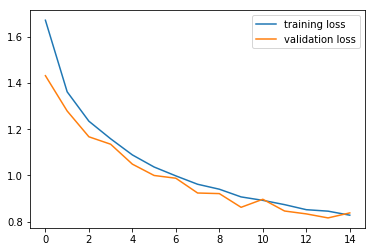

In [30]:
plt.plot(running_loss_history, label = 'training loss')
plt.plot(val_running_loss_history, label= 'validation loss')
plt.legend()

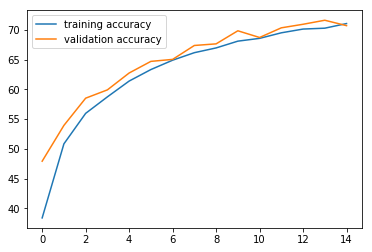

In [31]:
plt.plot(running_corrects_history ,label ='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [32]:
!pip3 install pillow==4.0.0

  Using cached https://files.pythonhosted.org/packages/37/e8/b3fbf87b0188d22246678f8cd61e23e31caa1769ebc06f1664e2e5fe8a17/Pillow-4.0.0-cp36-cp36m-manylinux1_x86_64.whl
ERROR: torchvision 0.3.0 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
ERROR: scikit-image 0.15.0 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 6.1.0
    Uninstalling Pillow-6.1.0:
      Successfully uninstalled Pillow-6.1.0


In [0]:
import PIL.ImageOps

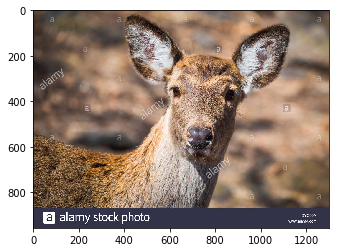

In [34]:
import requests
from PIL import Image
 
url = 'https://c8.alamy.com/comp/DYC06A/hornless-reindeer-at-zoo-DYC06A.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

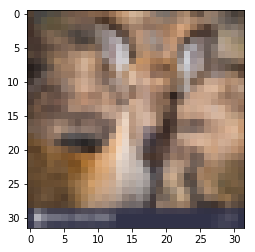

In [35]:
img = transform(img)
plt.imshow(im_convert(img))

In [36]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])


deer


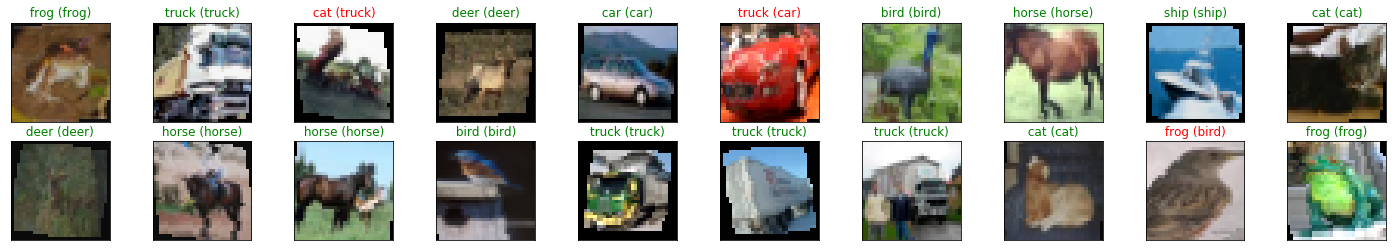

In [37]:
# creating a iterator 
# iter creates an object that allows us to go through the iterable of training loader one element at a time 
dataiter = iter(validation_loader)
images , labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)



output = model(images)
_,preds = torch.max(output, 1)


fig = plt.figure(figsize =(25,4))

for idx in np.arange(20):
  ax =fig.add_subplot(2,10,idx+1,xticks =[],yticks =[])   # 2 rows 10 columns per row and index
  plt.imshow(im_convert(images[idx]))
  ax.set_title(" {} ({}) ".format(str(classes[preds[idx].item()]),str(classes[labels[idx].item()])), color= "green" if preds[idx]==labels[idx] else "red")